In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import SIEMENSLONGBOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import (
    series_number, acquisition_number, coil_elements,
    qa_date, scanner_operator, larmor_frequency,
    tales_reference_power, transmitter_calibration,
    gradient_sensitivities, software_versions
)

# -- Watermark ---
wm = watermark()
display(
    pd.DataFrame(
        {'Watermark': list(wm.values())},
        index=wm.keys())
)

Watermark
CalculationTime  2023-01-29T02:29:13+00:00
User                      birchhub/jd14846
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.13
dcmextras                            0.3.0
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

### Details of series to Analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner          MRC25843
Date             20220913
Patient  AQA20220913BRIAV
Study                   1

# Summary
Tests performed:

- Slice shape and profile
- Geometric distortion and linearity
- Resolution
- Ghosting
- Head coil image uniformity
- Head coil SNR

All of the above are acceptable.

----

### Recommended Actions

No actions necessary.

In [3]:
aqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=365)).strftime('%B %Y')

text = f'''
This machine is next due for Annual QA tests in {aqadate}.
'''

HTMLLatex(text, text)

----

In [4]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\vfill',
        '\n',
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [5]:
NewPage

# Detailed Results
The detailed results for each of the tests run are presented below.

----

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a T<sub>E</sub> of 30ms using the PIQT slice profile block.

### 3 mm Slice

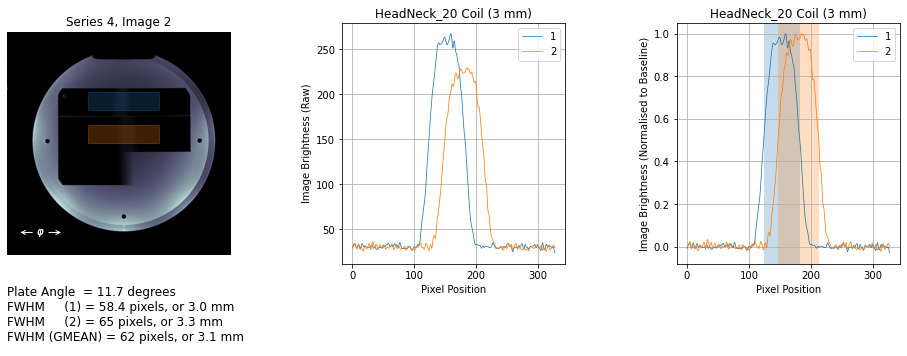

In [6]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series)
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

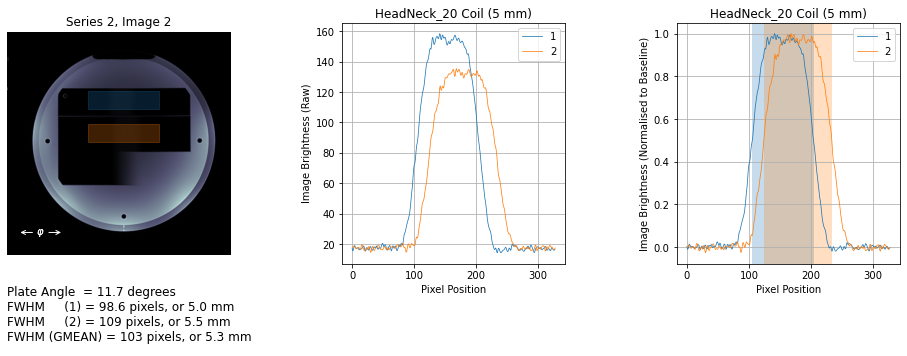

In [7]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series)
result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [8]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                62.0             3.1
5.0                               103.9             5.3

These are both rather rounded profiles as seen on other Siemens scanners with this protocol. The profile widths, though, are well within the AAPM tolerance of 0.5mm.

In [9]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are *after* applying Siemens 2D distortion correction.

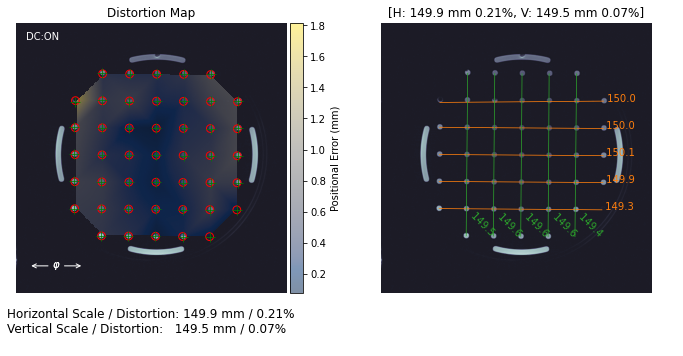

In [10]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

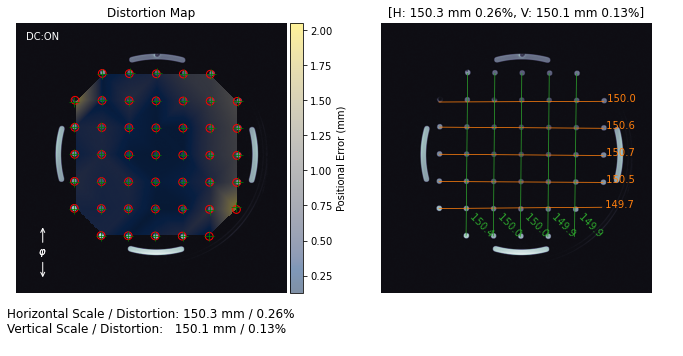

In [11]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialAP_Corrected'])[slices['AxialAP_Corrected']]
results = results.append(piqt_distortion_report(dobj))

In [12]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion (%)',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion (%)'  
})

Orientation Phase Direction  Horizontal Scale (mm)  \
Series                                                      
4            Axial              RL                149.872   
6            Axial              AP                150.308   

        Horizontal Distortion (%)  Vertical Scale (mm)  \
Series                                                   
4                           0.209              149.550   
6                           0.256              150.053   

        Vertical Distortion (%)  
Series                           
4                         0.067  
6                         0.130

The scale and distortion in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [13]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom. These results are from an axial slice acquired using a conventional spin echo.

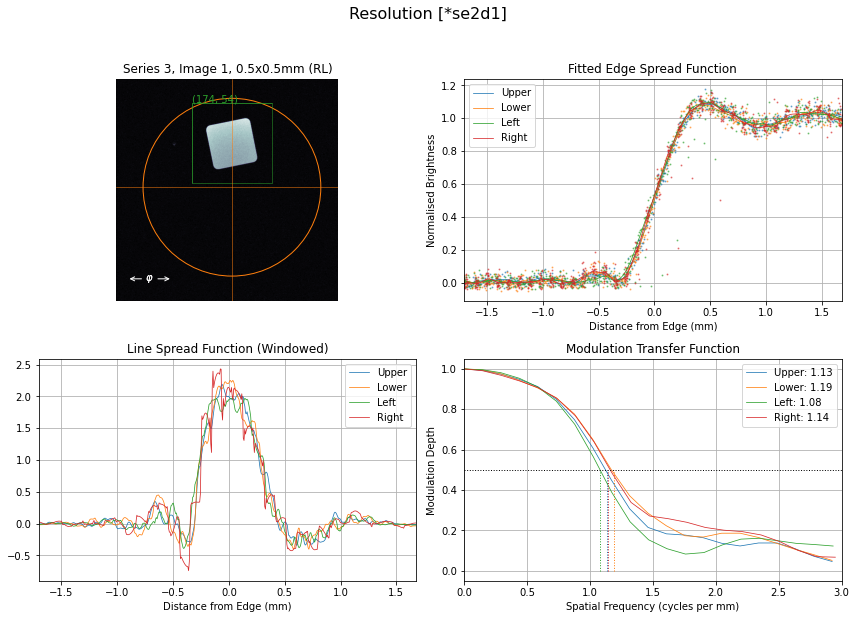

MTF_50
Upper   1.134
Lower   1.193
Left    1.077
Right   1.144

In [14]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']]), key=lambda d: int(d.InstanceNumber))
dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]

results = mtf_report(dobj_mtf, dobj_centre)
plt.show()
results

The MTF_50 is consistent with the nominal image resolution of 0.5 x 0.5 mm.

In [15]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

In [16]:
# jury-rigged ghosting report to address mask coordinate issue

#import numpy as np
#import pandas as pd

from scipy.ndimage.interpolation import zoom as ndizoom

#import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from mriqa.phantoms import GE10CMSPHERE, find_phantom, circular_mask, rectangular_mask

from mriqa.dcmio import (
    number_of_frames, pix_spacing_yx, approx_phase_orientation,
    approx_slice_orientation, seq_name, protocol_name, matrix_yx,
    series_number, t_r, t_e, readout_bandwidth, phase_enc_dirn
)

from mriqa.tools import add_phase_encode_mark, image_from_dicom


def _interpolate_to_min_resolution(image, min_matrix):
    """
    Interpolate to minum matrix size.
    Returns (possibly) interpolated image and pixel size scale factors
    """
    # Interpolate up to min_matrix * min_matrix if less
    old_ny, old_nx = image.shape
    assert old_nx == old_ny
    if old_ny < min_matrix:
        image = ndizoom(image, zoom=min_matrix/old_ny)
        new_ny, new_nx = image.shape
        return image, old_ny / new_ny, old_nx / new_nx
    return image, 1.0, 1.0

def ghosting_report(dobjs, phantom=GE10CMSPHERE, frame=None, axes=None):
    """
    Report on ghosting from a spherical phantom (or cylindrical for single axis)

    Based on images acquired of a small phantom.
    Produces image plots and returns a dataframe of results.

    """
    assert 1 <= len(dobjs) <= 6, 'Require 1-6 images (%d)' % len(dobjs)
    assert all(
        seq_name(d) == seq_name(dobjs[0]) for d in dobjs
    ), 'Sequences must be consistent (%s)' % [seq_name(d) for d in dobjs]
    assert all(
        pix_spacing_yx(d) == pix_spacing_yx(dobjs[0]) for d in dobjs
    ), 'Pixel spacings must be consistent %s' % [pix_spacing_yx(d) for d in dobjs]
    assert all(
        (d.Rows, d.Columns) == (dobjs[0].Rows, dobjs[0].Columns) for d in dobjs
    ), 'Matrix sizes must be consistent'
    # Square pixels only
    assert np.isclose(*pix_spacing_yx(dobjs[0])), 'Pixels must be square'

    if axes is None:
        fig, axs2 = plt.subplots(len(dobjs), 2, figsize=(10, 4*len(dobjs)))
        if len(axs2.shape) < 2:
            axs2 = [axs2]
    else:
        figs = [a.get_figure() for a in axes]
        assert len(set(figs)) == 1
        fig = figs[0]
        axs2 = list(zip(axes[0::2], axes[1::2]))

    # TODO: this is messy with a 2d array of axes - we want to flatten this ...
    # Display images and collect results in pandas df, one row per dicom object
    results = None
    for dobj, axs in zip(dobjs, axs2):
        # Image data
        image = image_from_dicom(dobj, frame, dtype=float)
        pix_dims = pix_spacing_yx(dobj)

        # Interpolate up to 256*256 if less
        image, scale_y, scale_x = _interpolate_to_min_resolution(image, 256)
        pix_dims = pix_dims[0] * scale_y, pix_dims[1] * scale_x
        ny, nx = image.shape

        # Find the phantom
        expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
        centre_x, centre_y, radius = find_phantom(image, expected_radius)

        # Phantom ROI
        phantom_mask = circular_mask(image, 0.85 * radius, centre_x, centre_y)
        margin_w = int(round(centre_x - 1.25 * radius,0))
        margin_e = int(round(centre_x + 1.25 * radius,0))
        margin_n = int(round(centre_y - 1.25 * radius,0))
        margin_s = int(round(centre_y + 1.25 * radius,0))

        # Ghost ROIs
        ghost_mask_w = rectangular_mask(image, 0, margin_w, margin_n, margin_s)
        ghost_mask_e = rectangular_mask(image, margin_e, nx-1, margin_n, margin_s)
        ghost_mask_n = rectangular_mask(image, margin_w, margin_e, 0, margin_n)
        ghost_mask_s = rectangular_mask(image, margin_w, margin_e, margin_s, ny-1)

        # Intensities in ROIs
        s_p = np.ma.masked_where(~phantom_mask, image).mean()
        s_n = np.ma.masked_where(~ghost_mask_n, image).mean()
        s_s = np.ma.masked_where(~ghost_mask_s, image).mean()
        s_e = np.ma.masked_where(~ghost_mask_e, image).mean()
        s_w = np.ma.masked_where(~ghost_mask_w, image).mean()

        # Ghost Ratio
        aapm_gr = abs(((s_w + s_e) - (s_n + s_s)) / (2 * s_p))

        # Standard windowed image with detected phantom position
        axs[0].imshow(image, cmap='bone')
        axs[0].imshow(phantom_mask, cmap='rainbow', alpha=0.25)
        axs[0].axis('image')
        axs[0].axis('off')
        axs[0].add_artist(
            plt.Circle((centre_x, centre_y), radius=radius, color='r', fill=False)
        )
        axs[0].set_title(protocol_name(dobj).ljust(20)[:20].strip('_'))

        # Show phase encoding direction
        add_phase_encode_mark(axs[0], phase_enc_dirn(dobj))

        # Low windowed image to show ghosts with ROIs
        mask_cmap = ListedColormap([
            (0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)
        ])

        # Try and make "ghost" window more robust using the 98th percentile
        # of the background instead of fixed 0.02 times the phantom maximum
        vmax = np.percentile(
            np.ma.array(
                image,
                mask=~(ghost_mask_w | ghost_mask_e | ghost_mask_n | ghost_mask_s)
            ).compressed(),
            98
        )
        axs[1].imshow(
            np.where(image > 0, image, 0),
            cmap='viridis', vmax=vmax
        )
        axs[1].imshow(
            ghost_mask_n | ghost_mask_s | ghost_mask_e | ghost_mask_w,
            vmax=1, cmap=mask_cmap, alpha=0.25
        )
        axs[1].axis('image')
        axs[1].axis('off')
        axs[1].set_title(
            '%s(%s): Image %d:%d, GR:%0.2f%%' % (
                approx_slice_orientation(dobj), approx_phase_orientation(dobj),
                series_number(dobj), dobj.InstanceNumber, 100 * aapm_gr
            )
        )

        field_of_view_mm = (
            matrix_yx(dobj)[0] * pix_spacing_yx(dobj)[0],
            matrix_yx(dobj)[1] * pix_spacing_yx(dobj)[1]
        )

        result = pd.DataFrame.from_dict({
            'Series':         [series_number(dobj)],
            'Frames':         [number_of_frames(dobj)],
            'TR':             [t_r(dobj)],
            'TE':             [t_e(dobj)],
            'Matrix':         [matrix_yx(dobj)],
            'Sequence':       [seq_name(dobj)],
            'FoV':            [field_of_view_mm],
            'Bandwidth':      [readout_bandwidth(dobj)],
            'PhaseAxis':      [phase_enc_dirn(dobj)],
            'PhaseDirection': [approx_phase_orientation(dobj)],
            'Protocol':       [protocol_name(dobj)],
            'Orientation':    [approx_slice_orientation(dobj)],
            'Phantom':        [s_p],
            'Left':           [s_w],
            'Right':          [s_e],
            'Top':            [s_n],
            'Bottom':         [s_s],
            'GhostRatio':     [100 * aapm_gr]
        }).set_index('Series')

        results = result if results is None else results.append(result)

    fig.suptitle('Ghosting [%s]' % seq_name(dobj), fontsize=16)

    return results

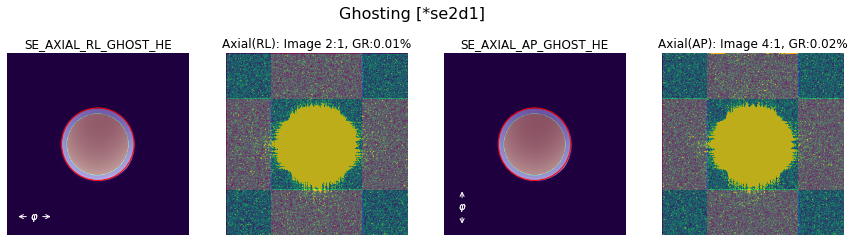

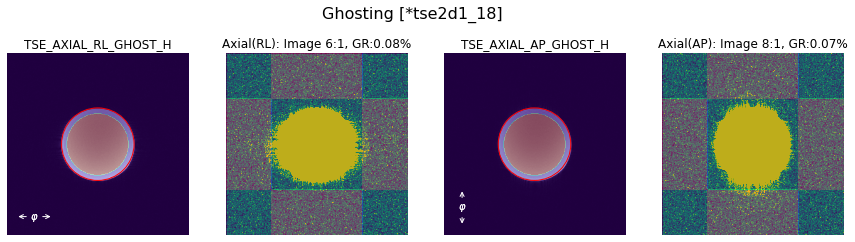

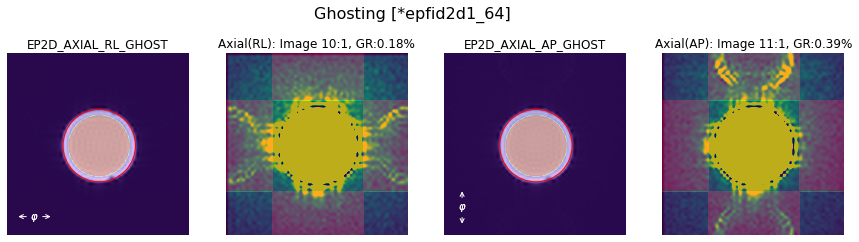

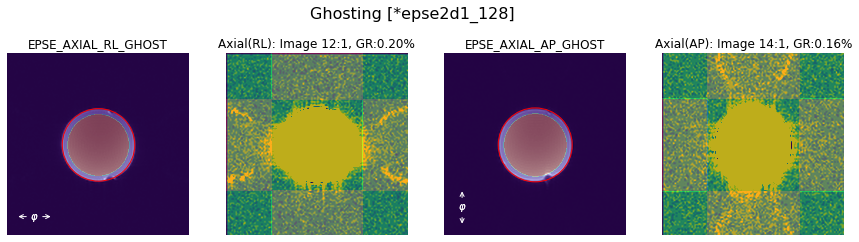

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
2             *se2d1       Axial              RL            0.007
4             *se2d1       Axial              AP            0.022
6         *tse2d1_18       Axial              RL            0.075
8         *tse2d1_18       Axial              AP            0.073
10      *epfid2d1_64       Axial              RL            0.176
11      *epfid2d1_64       Axial              AP            0.389
12      *epse2d1_128       Axial              RL            0.197
14      *epse2d1_128       Axial              AP            0.160

In [17]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The worst ghosting is seen on the GRE EPI (EP_2D/epfid).

In [18]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a spherical phantom filled with a silicone oil. Results are presented both before and after Siemens `prescan-normalize` intensity correction.

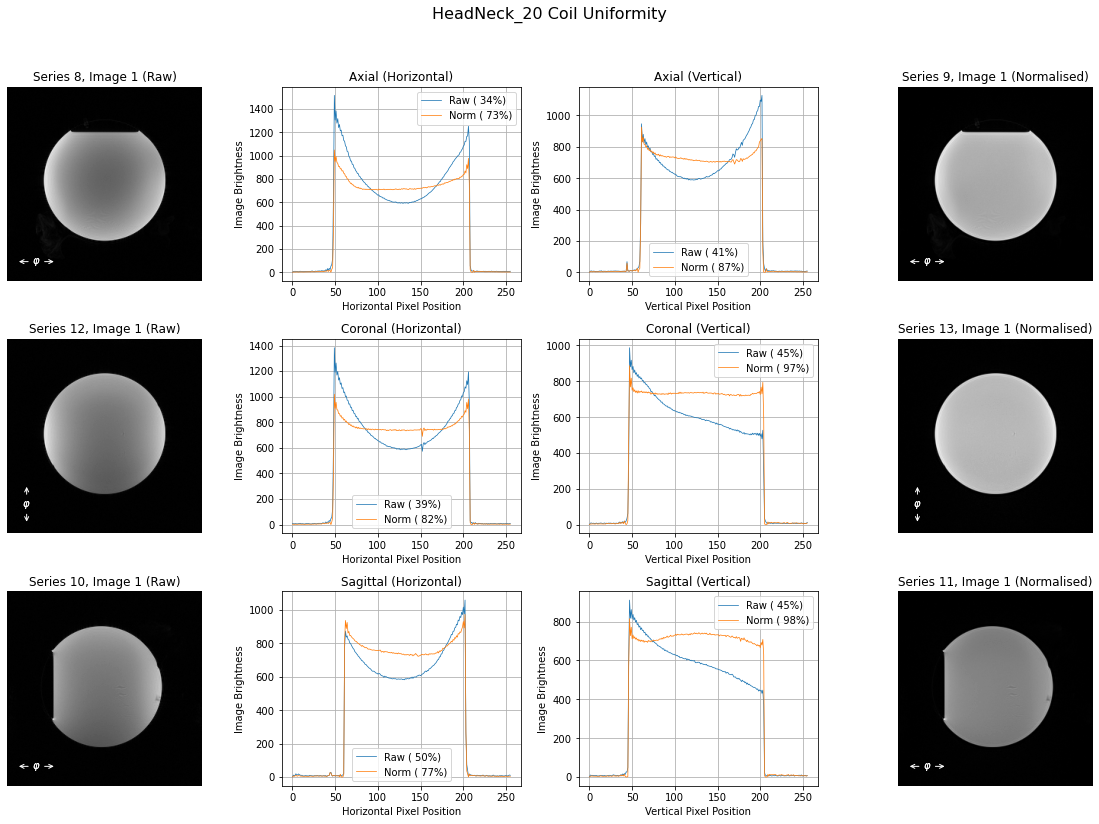

Raw Images


Series No.                                   Protocol  \
Orientation                                                          
Axial                 8     SE_AXIAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Coronal              12   SE_CORONAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Sagittal             10  SE_SAGITTAL_AP_UNIF_HEAD_OILSPHERE_TR1000   

                    Axis   X Uniformity (%)  Y Uniformity (%)  
Orientation                                                    
Axial           Axial/RL              33.75             40.97  
Coronal       Coronal/HF              38.75             45.28  
Sagittal     Sagittal/AP              49.65             44.65

Intensity Normalised Images


Series No.                                   Protocol  \
Orientation                                                          
Axial                 9     SE_AXIAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Coronal              13   SE_CORONAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Sagittal             11  SE_SAGITTAL_AP_UNIF_HEAD_OILSPHERE_TR1000   

                    Axis   X Uniformity (%)  Y Uniformity (%)  
Orientation                                                    
Axial           Axial/RL              73.12             86.71  
Coronal       Coronal/HF              82.50             96.86  
Sagittal     Sagittal/AP              76.92             98.11

In [19]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalize` intensity correction is generally adequate in compensating for this.

In [20]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 20 Channel Head/Neck Coil

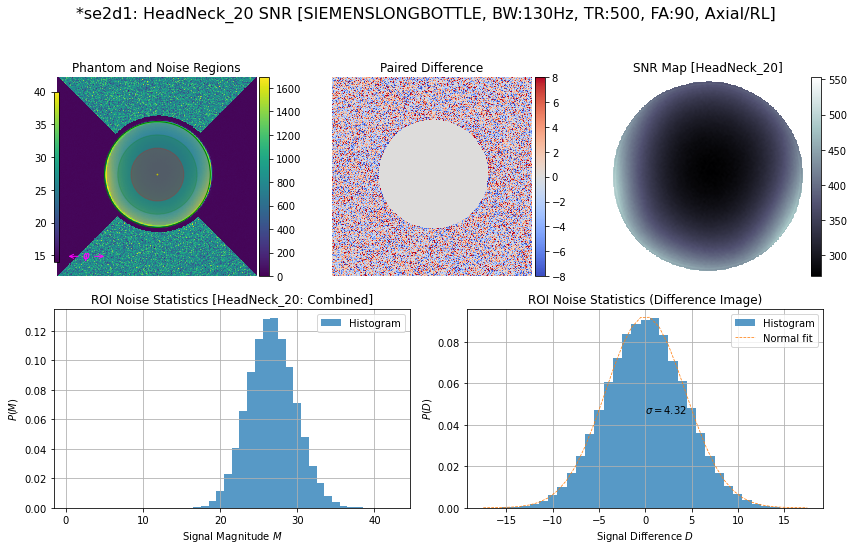

SNR: Raw Images


HeadNeck_20
RegionSize             
0.50              291.0
0.75              316.0

In [21]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are consistent with previous results from this scanner and similar to those we have obtained on other 1.5T Siemens scanners under these conditions.

In [22]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

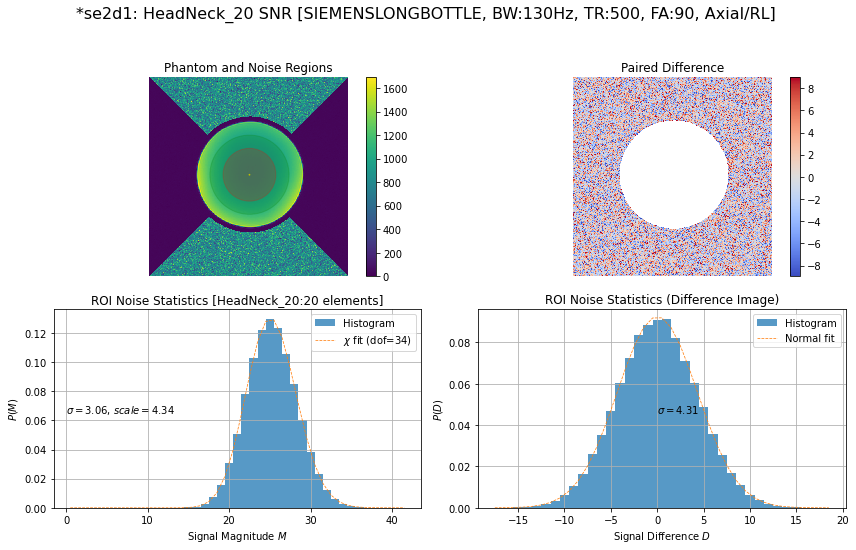

HeadNeck_20
0.50       291.02
0.75       315.80

In [23]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

results = snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE)
plt.show()
with pd.option_context('display.precision', 2):
    display(results)

These results are consistent with previous results from this scanner and similar to those we have obtained on other 1.5T Siemens scanners under these conditions.

In [24]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM header of the Localizer scan.

In [25]:
# Siemens Long Bottle: localizer
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

df = pd.DataFrame({
    'SoftwareVersions': [software_versions(dobj)],
    'ImagingFrequency': [larmor_frequency(dobj)],
    'TransmitterCalibration': [transmitter_calibration(dobj)],
    'TalesReferencePower': [tales_reference_power(dobj)],
    'GradientSensitivityX': [
        float(gradient_sensitivities(dobj)[0]) * 1e6,
    ],
    'GradientSensitivityY': [
        float(gradient_sensitivities(dobj)[1]) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(gradient_sensitivities(dobj)[2]) * 1e6,
    ]
}, index=['Value']).T
df

Value
SoftwareVersions        syngo MR E11
ImagingFrequency              63.571
TransmitterCalibration       222.932
TalesReferencePower          517.479
GradientSensitivityX          78.149
GradientSensitivityY          78.723
GradientSensitivityZ          90.411